# Data preparation 

Let's first only classify 30 dog breed from Standford dataset. 
Which are the one with the most images provided (number of images superior to the third inter-quartile)

https://www.youtube.com/watch?v=7Mv91hcxCCI&t=137s

In [80]:
%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import cv2 
# importing shutil module 
import shutil 
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
from common_params import data_dir, img_dir
from common_plots import display_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(tf.__version__)

2.11.0


In [4]:
data = pd.read_csv("selected_breed.csv")


In [5]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,dog_breed,folder_name,image_count
0,Maltese_dog,n02085936-Maltese_dog,252.0
1,Afghan_hound,n02088094-Afghan_hound,239.0
2,Scottish_deerhound,n02092002-Scottish_deerhound,232.0
3,Pomeranian,n02112018-Pomeranian,219.0
4,Samoyed,n02111889-Samoyed,218.0


### Load images 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

In [168]:
IMG_SIZE = 224
batch_size = 32

input_shape = (224, 224, 3) 

## DO NOT TAKE ALL IMAGES FROM DATASET 

In [261]:
TAKE_ALL = True # for the moment only take 10 imgs per class 
NB_IMG_PER_CLASS = 10 
if TAKE_ALL == True : 
    sub_directory = "30_classes_all"
else : 
    sub_directory = "images_subset"

# Add : only take 30 classes

In [262]:


imgsub_dir = os.path.join(data_dir,sub_directory)
if not os.path.isdir(imgsub_dir) : 
    os.mkdir(os.path.join(data_dir,sub_directory))


In [265]:

for folder in data["folder_name"].tolist() : 
    location = os.path.join(img_dir,folder)
    destination = os.path.join(imgsub_dir,folder)
    print(location, destination)

    if TAKE_ALL : 
        dest = shutil.copytree(location, destination)
    else : 
        if not os.path.isdir(destination) : 
            os.mkdir(destination)
        files = os.listdir(location)
        i = 0 
        while i < NB_IMG_PER_CLASS : 
            file_name = files[i]
            file_location = os.path.join(location, file_name)
            file_destination =  os.path.join(destination, file_name)
            print(file_location)
            print(file_destination)
            dest = shutil.copyfile(file_location, file_destination)
            print(dest)
            i = i +  1 

C:/dev/image_classification/data/Images/n02085936-Maltese_dog C:/dev/image_classification/data/30_classes_all\n02085936-Maltese_dog
C:/dev/image_classification/data/Images/n02088094-Afghan_hound C:/dev/image_classification/data/30_classes_all\n02088094-Afghan_hound
C:/dev/image_classification/data/Images/n02092002-Scottish_deerhound C:/dev/image_classification/data/30_classes_all\n02092002-Scottish_deerhound
C:/dev/image_classification/data/Images/n02112018-Pomeranian C:/dev/image_classification/data/30_classes_all\n02112018-Pomeranian
C:/dev/image_classification/data/Images/n02111889-Samoyed C:/dev/image_classification/data/30_classes_all\n02111889-Samoyed
C:/dev/image_classification/data/Images/n02090721-Irish_wolfhound C:/dev/image_classification/data/30_classes_all\n02090721-Irish_wolfhound
C:/dev/image_classification/data/Images/n02107683-Bernese_mountain_dog C:/dev/image_classification/data/30_classes_all\n02107683-Bernese_mountain_dog
C:/dev/image_classification/data/Images/n020

In [266]:
train_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgsub_dir,
    seed=59,
    # labels= "inferred",
    subset="both",
    # label_mode='categorical',
    validation_split=0.2,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
    )


Found 6164 files belonging to 30 classes.
Using 4932 files for training.
Using 1232 files for validation.


In [267]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes

30

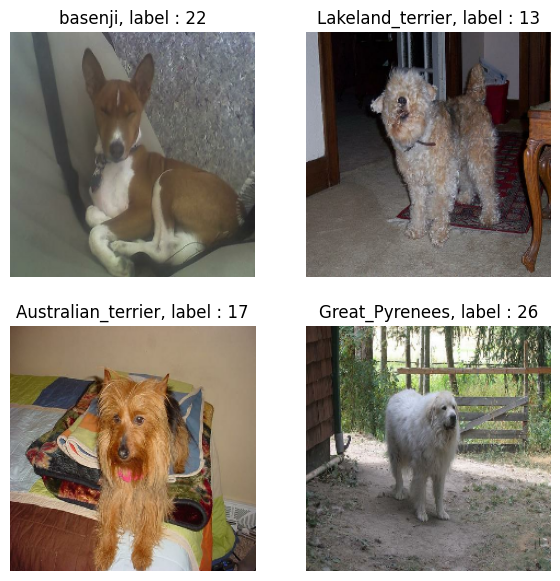

In [157]:
plt.figure(figsize=(7, 7))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]].split('-')[1]}, label : {labels[i]}")
        plt.axis("off")

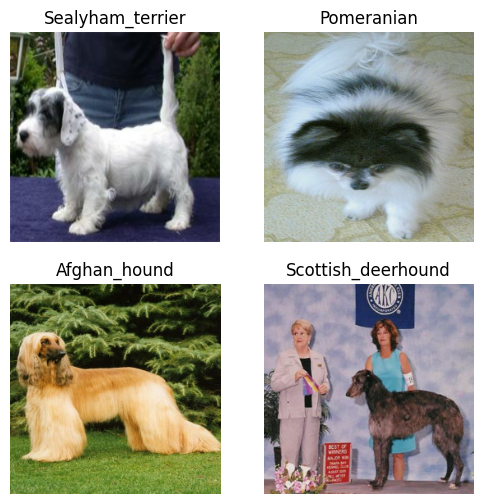

In [53]:
plt.figure(figsize=(6, 6))
class_names = validation_ds.class_names
for images, labels in validation_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].split('-')[1])
        plt.axis("off")

# Data augmentation 

In [54]:
data_augmentation = tf.keras.Sequential(
    [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1)
            
    ]
)

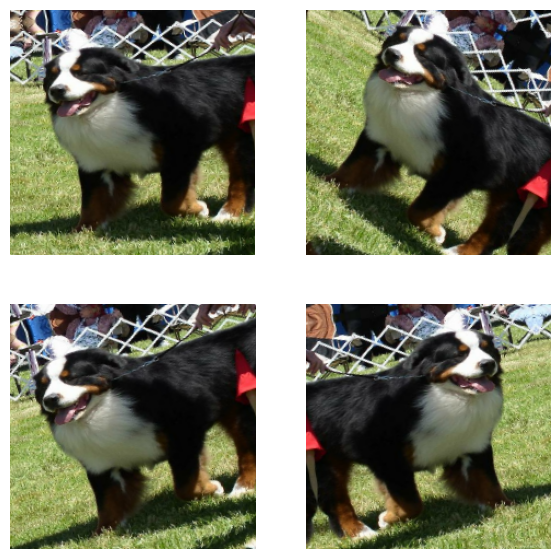

In [112]:

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [209]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU available : {len(physical_devices)}")

Number of GPU available : 0


# Standardize

In [268]:
if len(physical_devices) == 0 : 
    augmented_train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y))
else : 
    # Apply `data_augmentation` to the training images.
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    # Prefetching samples in GPU memory helps maximize GPU utilization.
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)
    
# One -Hot on labels 
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
validation_ds = validation_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0.], shape=(30,), dtype=float32)
27
n02111889-Samoyed


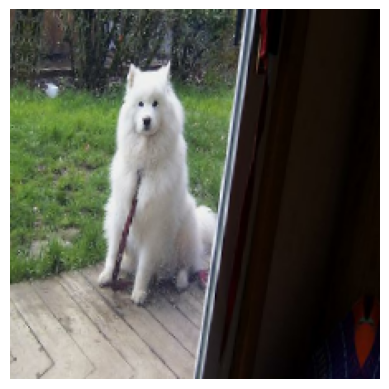

In [296]:
for img, labels in train_ds.take(1) :
    img_array = keras.utils.img_to_array(img[0])
    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    
    print(labels[0])
    label_arg = np.argmax(labels[0])
    print(label_arg)
    print(class_names[label_arg])


# My convolutional neural network 

In [275]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling

def get_personal_model():
    model = Sequential()
    model.add(Input(shape=input_shape)) 
    model.add(Rescaling( 1.0 / 255 ))
    
    model.add(Conv2D(32, (3, 3), activation='relu')) # kernel = 3*3
    model.add(MaxPooling2D((2, 2),strides=(2,2),padding="same"))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='softmax'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model 

In [276]:
cnn_based_model = get_personal_model()

In [279]:
cnn_based_model.build(input_shape)

ValueError: Input 0 of layer "conv2d_16" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (224, 224, 3)

In [277]:
keras.utils.plot_model(cnn_based_model, show_shapes=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [273]:
cnn_based_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 256)     

In [274]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

history = cnn_based_model.fit(
    train_ds,
    epochs=2,
    callbacks=callbacks,
    validation_data=validation_ds)

Epoch 1/5
155/155 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.0351

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


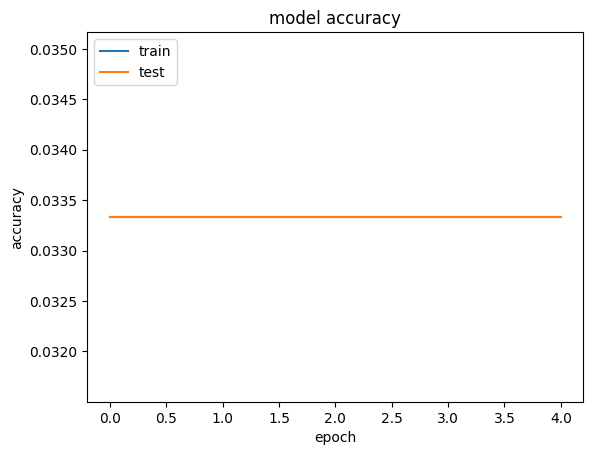

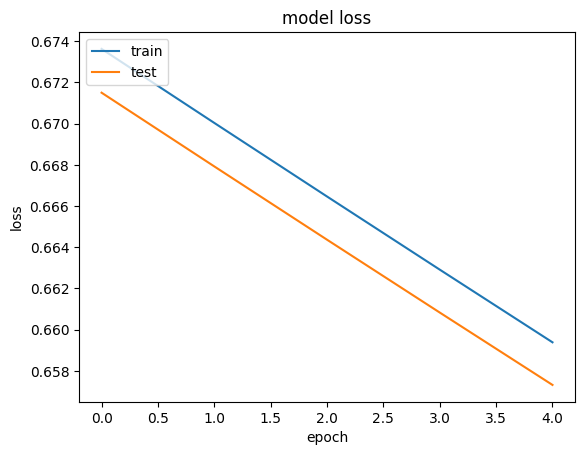

In [258]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [249]:
img = keras.utils.load_img(
    os.path.join(img_dir,"n02085620-Chihuahua\\n02085620_7.jpg"), target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = cnn_based_model.predict(img_array)
print(predictions)


1/1 [==============================] - 0s 215ms/step
[[0.03336657 0.03330528 0.03331576 0.03332538 0.03333196 0.03331489
  0.03330834 0.03335355 0.03337905 0.0333891  0.03329747 0.03330733
  0.03329911 0.03336873 0.03330065 0.03335722 0.0333079  0.03332188
  0.0333128  0.03337359 0.033304   0.0333653  0.03336687 0.0333185
  0.0333299  0.0333218  0.03339823 0.03334411 0.03330163 0.03331314]]


In [251]:
score = np.argmax(predictions)
score

26

In [255]:
print(f"This image is more likely to be a {class_names[score].split('-')[1]}")

This image is more likely to be a Great_Pyrenees
